In [76]:
from __future__ import division, print_function
# coding=utf-8
import sys
import os
import time
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np
import pandas as pd
from datetime import datetime
from IPython.display import display, HTML
from pprint import pprint

import matplotlib.pyplot
import matplotlib.pyplot as plt

from keras.preprocessing import image
from keras.applications import VGG16
from keras.applications.imagenet_utils import preprocess_input as preprocess_input_vgg
from keras.applications.inception_v3 import preprocess_input as preprocess_input_inc
from keras.utils.np_utils import to_categorical
from keras.models import Model, load_model
from keras import metrics

import tables
import nmslib
#import falconn

from flask import Flask, redirect, url_for, request, render_template, stream_with_context, Response, send_from_directory
from werkzeug.utils import secure_filename

from chefkochParser import food_list_html
import logger

MODEL_PATH = 'models/inceptionv3_4_new_ohne_dpot_2.97270.hdf5'
MODEL_VGG_PATH = 'models/weights.bestVGG16try9.hdf5'
hdf5_PATH = 'models/vgg16_bottleneck_features.hdf5'
bin_PATH = 'models/dense_index_optim_01.bin'
CHEFKOCH_PATH = 'https://www.chefkoch.de/rezepte/'
model_inc = None
feat_extractor = None

hdf5_file = tables.open_file(hdf5_PATH, mode='r')
features = hdf5_file.root.img_features
images = hdf5_file.root.img_paths

#n = 403885
#n = 416791

# nmslib default params for now

# Number of neighbors
K = 18
# Set index parameters
# These are the most important ones
M = 15
efC = 100
num_threads = 4
index_time_params = {'M': M, 'indexThreadQty': num_threads, 'efConstruction': efC, 'post' : 0}
space_name='l2'
efS = 100
query_time_params = {'efSearch': efS}
index_ann = None

In [2]:
with open('meta/classes_230.txt', 'r') as textfile:
    categories = textfile.read().splitlines()

In [77]:
def create_ann_index(bin_PATH, num_features):
    global index_ann
    # Intitialize the library, specify the space, the type of the vector and add data points 
    index_ann = nmslib.init(method='hnsw', space=space_name, data_type=nmslib.DataType.DENSE_VECTOR) 
    index_ann.addDataPointBatch(features[:num_features])
    index_ann.createIndex(index_time_params, print_progress=True)
    # Setting query-time parameters and querying
    print('Setting query-time parameters', query_time_params)
    index_ann.setQueryTimeParams(query_time_params)

In [78]:
def init_ann_index(bin_PATH=bin_PATH):
    global index_ann
    # Intitialize the library, specify the space, the type of the vector and add data points 
    index_ann = nmslib.init(method='hnsw', space=space_name, data_type=nmslib.DataType.DENSE_VECTOR)
    # Re-load the index and re-run queries
    index_ann.loadIndex(bin_PATH)
    # Setting query-time parameters and querying
    print('Setting query-time parameters', query_time_params)
    index_ann.setQueryTimeParams(query_time_params)

In [ ]:
create_ann_index(bin_PATH, 400000)

In [80]:
init_ann_index()

Setting query-time parameters {'efSearch': 100}


In [84]:
def load_models(MODEL_PATH):
    global model_inc, feat_extractor
    model_inc = load_model(MODEL_PATH, custom_objects={'top_10_accuracy': top_10_accuracy})
    model_inc._make_predict_function()
    model_vgg = VGG16(weights='imagenet', include_top=True)
    #model_vgg = load_model(MODEL_VGG_PATH)
    feat_extractor = Model(inputs=model_vgg.input, outputs=model_vgg.get_layer("fc2").output)
    img, x = get_image_vgg("meta/kuchen.jpg")
    feat = feat_extractor.predict(x)
    print('Models loaded. Start serving...')

In [47]:
chefkoch_rezepte = pd.read_csv('meta/chefkoch.csv', index_col=False)

In [85]:
def top_10_accuracy(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=10)

# get_image will return a handle to the image itself, and a numpy array of its pixels to input the network
def get_image_vgg(path):
    img = image.load_img(path, target_size=feat_extractor.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input_vgg(x)
    return img, x
  
def get_image_inc(path):
    img = image.load_img(path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input_inc(x)
    return img, x
  
def plot_preds(image, probabilities, top_n):
    plt.imshow(image)
    plt.axis('off')
    plt.figure()
    
    order = list(reversed(range(top_n)))
    labels = [categories[x] for i, x in enumerate(np.argsort(-probabilities)[:top_n])]
    bar_preds = [-np.sort(-probabilities)[i] for i, x in enumerate(np.argsort(-probabilities)[:top_n])]
    
    plt.barh(order, bar_preds, alpha=0.8, color='g')
    plt.yticks(order, labels, color='g')
    plt.xlabel('Probability', color='g')
    plt.xlim(0, 1.01)
    plt.tight_layout()
    plt.show()

def show_result_images(final_result):
    rows = 6
    cols = 3
    fig, ax = plt.subplots(rows, cols, frameon=False, figsize=(12, 12))
    fig.suptitle('Result Images from Query', fontsize=20)
    food_dirs = [food_direction[4] for food_direction in final_result]
    for i in range(rows):
        for j in range(cols):
            food_dir = food_dirs[i*cols + j]
            img = plt.imread('/Users/Muriz/Desktop/Extracting-food-preferences-master/notebooks/input/images/'+food_dir)
            ax[i][j].imshow(img)
            ec = (0, .6, .1)
            fc = (1, 1, 1)
            ax[i][j].text(0, 0, get_corresponding_recipes(final_result).recipe_name[i*cols + j], size=15, rotation=0,
                ha="left", va="top", 
                bbox=dict(boxstyle="round", ec=ec, fc=fc))
    plt.setp(ax, xticks=[], yticks=[])
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

def get_closest_images_nmslib(query_features, num_results=K):
    return index_ann.knnQuery(query_features, k = num_results)
    
def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image

def get_corresponding_recipes(final_results, chefkoch_rezepte=chefkoch_rezepte):
    chefkoch_rezepte_result = pd.DataFrame()
    for recipe_id_single in final_results:
        chefkoch_rezepte_result = chefkoch_rezepte_result.append(chefkoch_rezepte.query('recipe_id in @recipe_id_single[2]'), ignore_index=True)
    return chefkoch_rezepte_result

In [86]:
load_models(MODEL_PATH)

Models loaded. Start serving...


In [125]:
def model_predict(img_path):
    query_image, x = get_image_vgg(img_path)
    query_features = feat_extractor.predict(x)[0]
    # do a query on a random image
    idx_closest, distances = get_closest_images_nmslib(query_features)
    # Don't forget to adjust string slicing for second hdf5
    # Labels only from ANN
    predicted_labels = [str(images[i]).split('/')[1] for i in idx_closest]
    # Results only from ANN
    predicted_ids = [[str(images[i]).split('-')[1], str(images[i]).split('-')[2].split('.')[0], images[i].decode("utf-8")] for i in idx_closest]

    # result_links = []
    # for id_food in predicted_ids:
    #     result_links.append(CHEFKOCH_PATH+id_food[0])
    # result = food_list_html(result_links)
    # result2=[]
    # for image_id in predicted_ids:
    #     result2.append(image_id[0])
    #     result2.append(image_id[1])
    # result = ' '.join(result2)


    img, x = get_image_inc(img_path)
    probabilities = model_inc.predict(x)[0]
    plot_preds(img, probabilities, 15)
    pred_categories = []

    for i, x in enumerate(np.argsort(-probabilities)[:K]):
        confidence = -np.sort(-probabilities)[i]
        #print(categories[x], confidence)
        pred_categories.append([categories[x], confidence])
      
    predicted_labels_with_weights = []
    for iii in predicted_labels:
        for iiii, ii in enumerate(pred_categories):
            no_result = False
            if ii[0] == iii:
                predicted_labels_with_weights.append([iii, ii[1]])
                break
            if iiii == len(pred_categories)-1:
                predicted_labels_with_weights.append([iii, 0])
          
    predicted_labels_with_meta = [xi+yi for xi, yi in zip(predicted_labels_with_weights, predicted_ids)]
    final_result = sorted(predicted_labels_with_meta, key=lambda predicted_labels_with_meta: predicted_labels_with_meta[1], reverse=True)
    
    final_result_ann = []
    
    for i in predicted_ids:
        i.insert(0, 0)
        i.insert(0, 0)
        final_result_ann.append(i)
    
    #show_result_images(final_result_ann)
    show_result_images(final_result)
    return final_result

[[ 'category', incep_confidence, recipe_id, image_index, image_path ], [], ...]

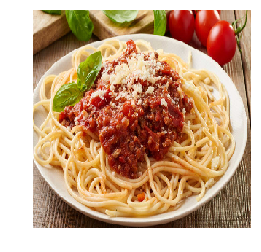

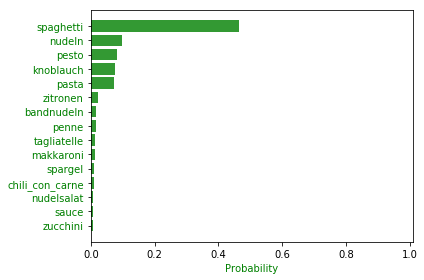

3085191461154045-Pfannen-Spaghetti
493951143751463-Spaghetti Napoli
176551077118022-Spaghetti mit Thunfisch
1792311289728753-Hüttenkäse - Kirschtomaten - Spaghetti
969381202627606-Spaghetti in einer Safran - Knoblauch - Soße mit frischem Fischfilet und Garnelen
114011047900894-Spaghetti gebraten mit Basilikum und Tomate
842311189503636-Spaghetti Frutti di Mare


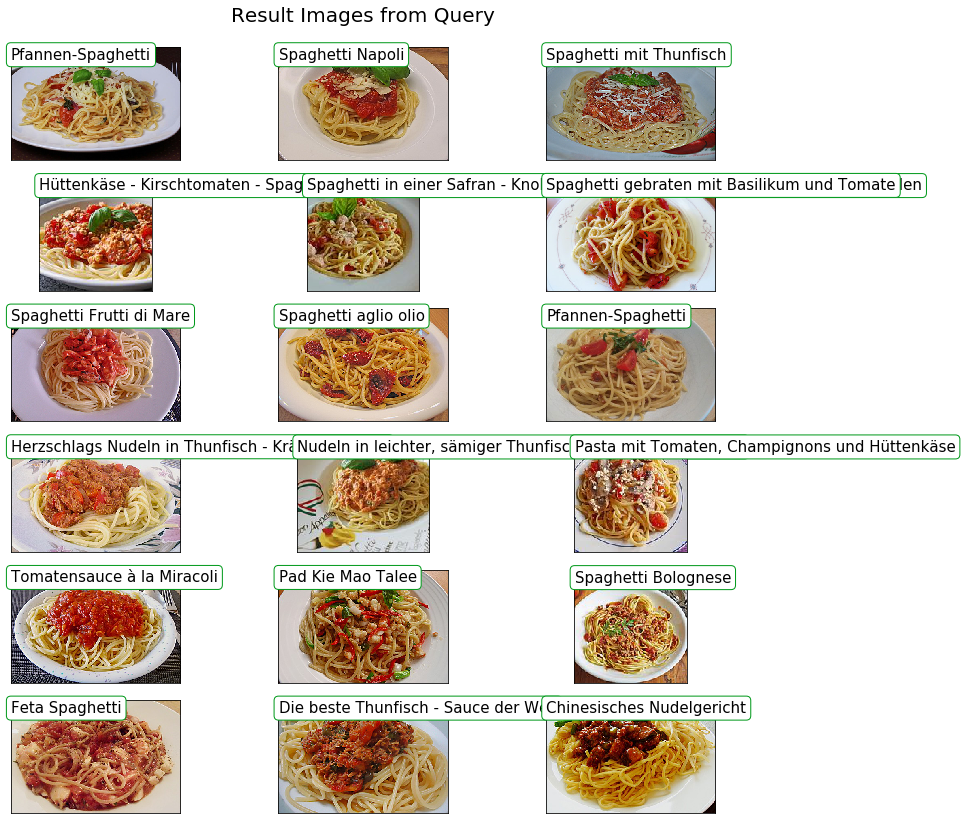

In [126]:
result_list = model_predict('uploads/4.jpg')
ids = [food_id[2] for food_id in result_list]
food = food_list_html(result_list=result_list[:7], online=False)

#pprint(result_list[:7])

#chart = HTML(''.join(map(str, food)))
#display(chart)